<a href="https://colab.research.google.com/github/GUNWOOOH/ADP_Practice/blob/main/%EA%B8%B0%EC%B6%9C%EB%B3%B5%EC%9B%90/%EA%B8%B0%EC%B6%9C%EB%B3%B5%EC%9B%90_ADP22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 확인 및 전처리

1.1 탐색적 데이터 분석 수행(시각화 포함)

1.2 이상치 처리(이상값 대체방안 제시)

1.3 앞선 두 단계에서 얻은 향후 분석시 고려사항 작성

 - 데이터 설명(피마 인디안 당뇨병 발병유무)

     - 신체스펙

     - Pregnancies

     - Glucose

     - BloodPressure

     - SkinThickness

     - Insulin

     - BMI

     - DiabetesPedigreeFunction

     - Age

     - 발병유무(종속변수) : Outcome

In [8]:
import numpy as np # 벡터, 행렬 등 수치 연산을 수행하는 선형대수 라이브러리
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/22/data1.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.isnull().sum() # 결측치 미존재

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
#이상치 확인

def boxplot_vis(data, target_name):
    plt.figure(figsize=(30, 30))
    for col_idx in range(len(data.columns)):
        # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
        plt.subplot(6, 2, col_idx+1)
        # flierprops: 빨간색 다이아몬드 모양으로 아웃라이어 시각화
        plt.boxplot(data[data.columns[col_idx]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
        # 그래프 타이틀: feature name
        plt.title("Feature" + "(" + target_name + "):" + data.columns[col_idx], fontsize = 20)
    plt.show()

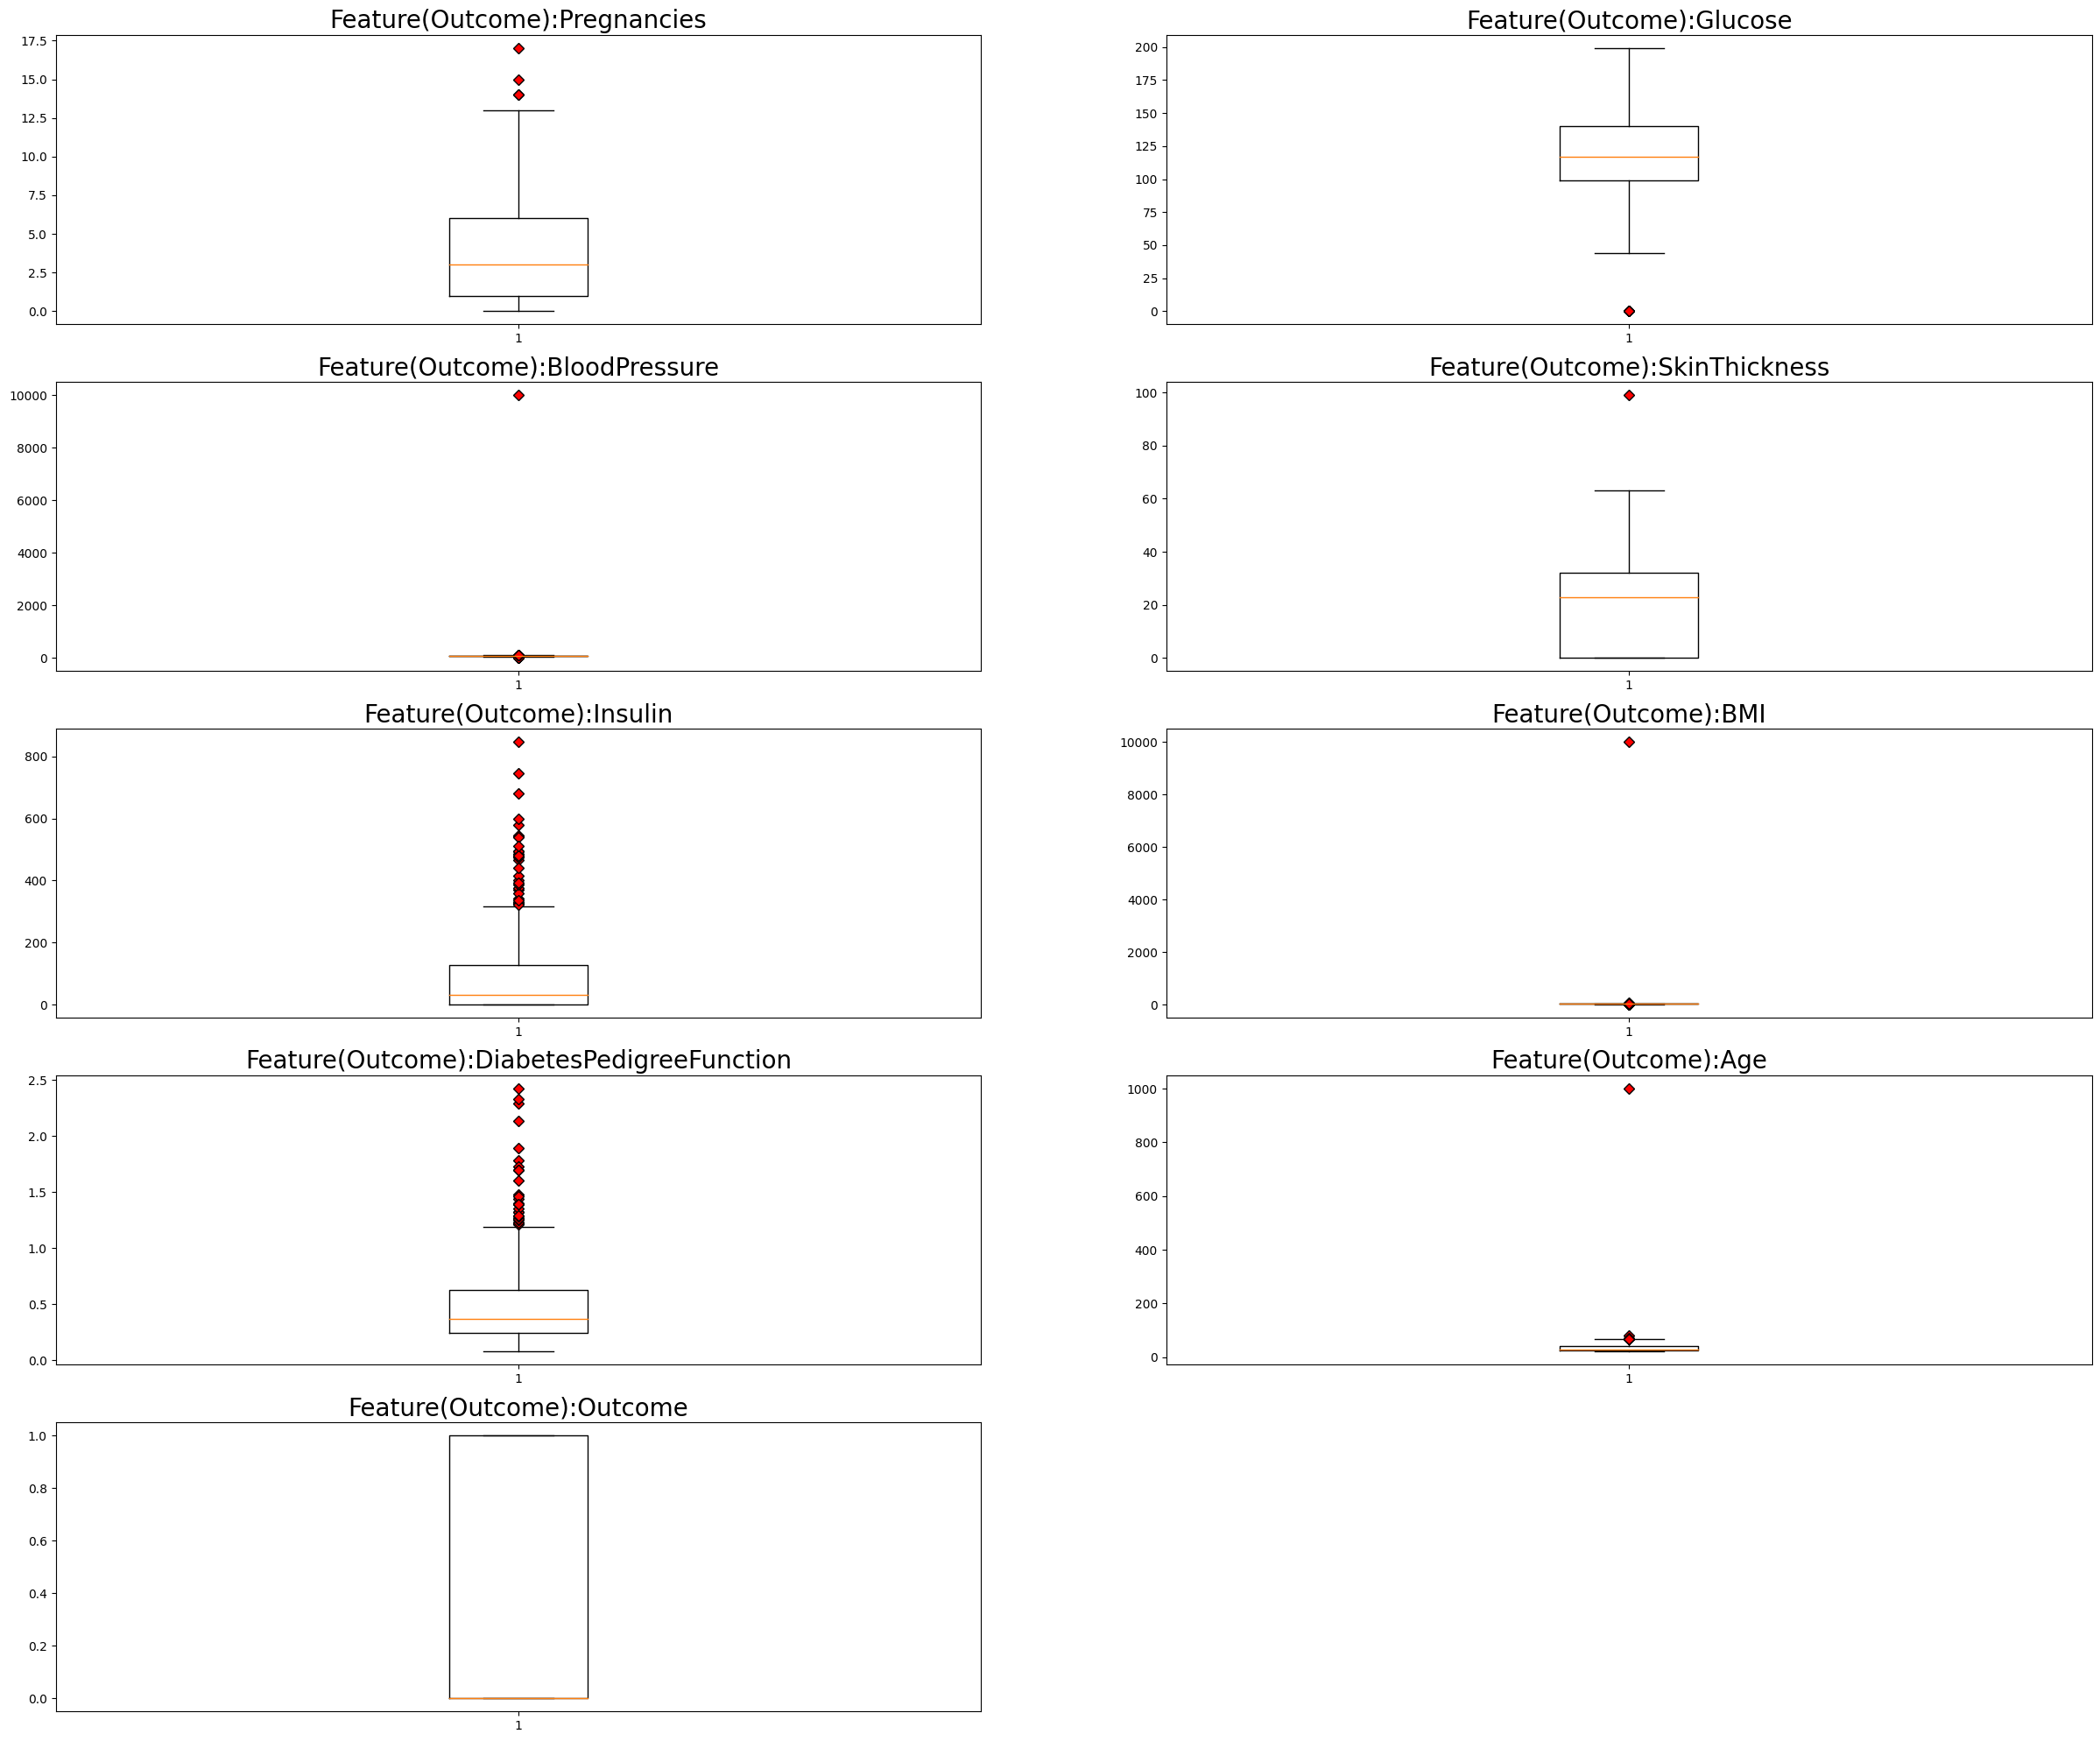

In [12]:
boxplot_vis(df, 'Outcome' )

In [13]:
def remove_outlier(input_data): #이상치제거
    q1 = input_data.quantile(0.25) # 제 1사분위수
    q3 = input_data.quantile(0.75) # 제 3사분위수
    iqr = q3 - q1 # IQR(Interquartile range) 계산
    minimum = q1 - (iqr * 1.5) # IQR 최솟값
    maximum = q3 + (iqr * 1.5) # IQR 최댓값
    # IQR 범위 내에 있는 데이터만 산출(IQR 범위 밖의 데이터는 이상치)
    df_removed_outlier = input_data[(minimum < input_data) & (input_data < maximum)]
    return df_removed_outlier

In [19]:
df_nooutlier = remove_outlier(df)

df_nooutlier.isnull().sum() #각 변수별 outlier 개수

Pregnancies                  4
Glucose                      5
BloodPressure               45
SkinThickness                1
Insulin                     34
BMI                         19
DiabetesPedigreeFunction    29
Age                          9
Outcome                      0
dtype: int64

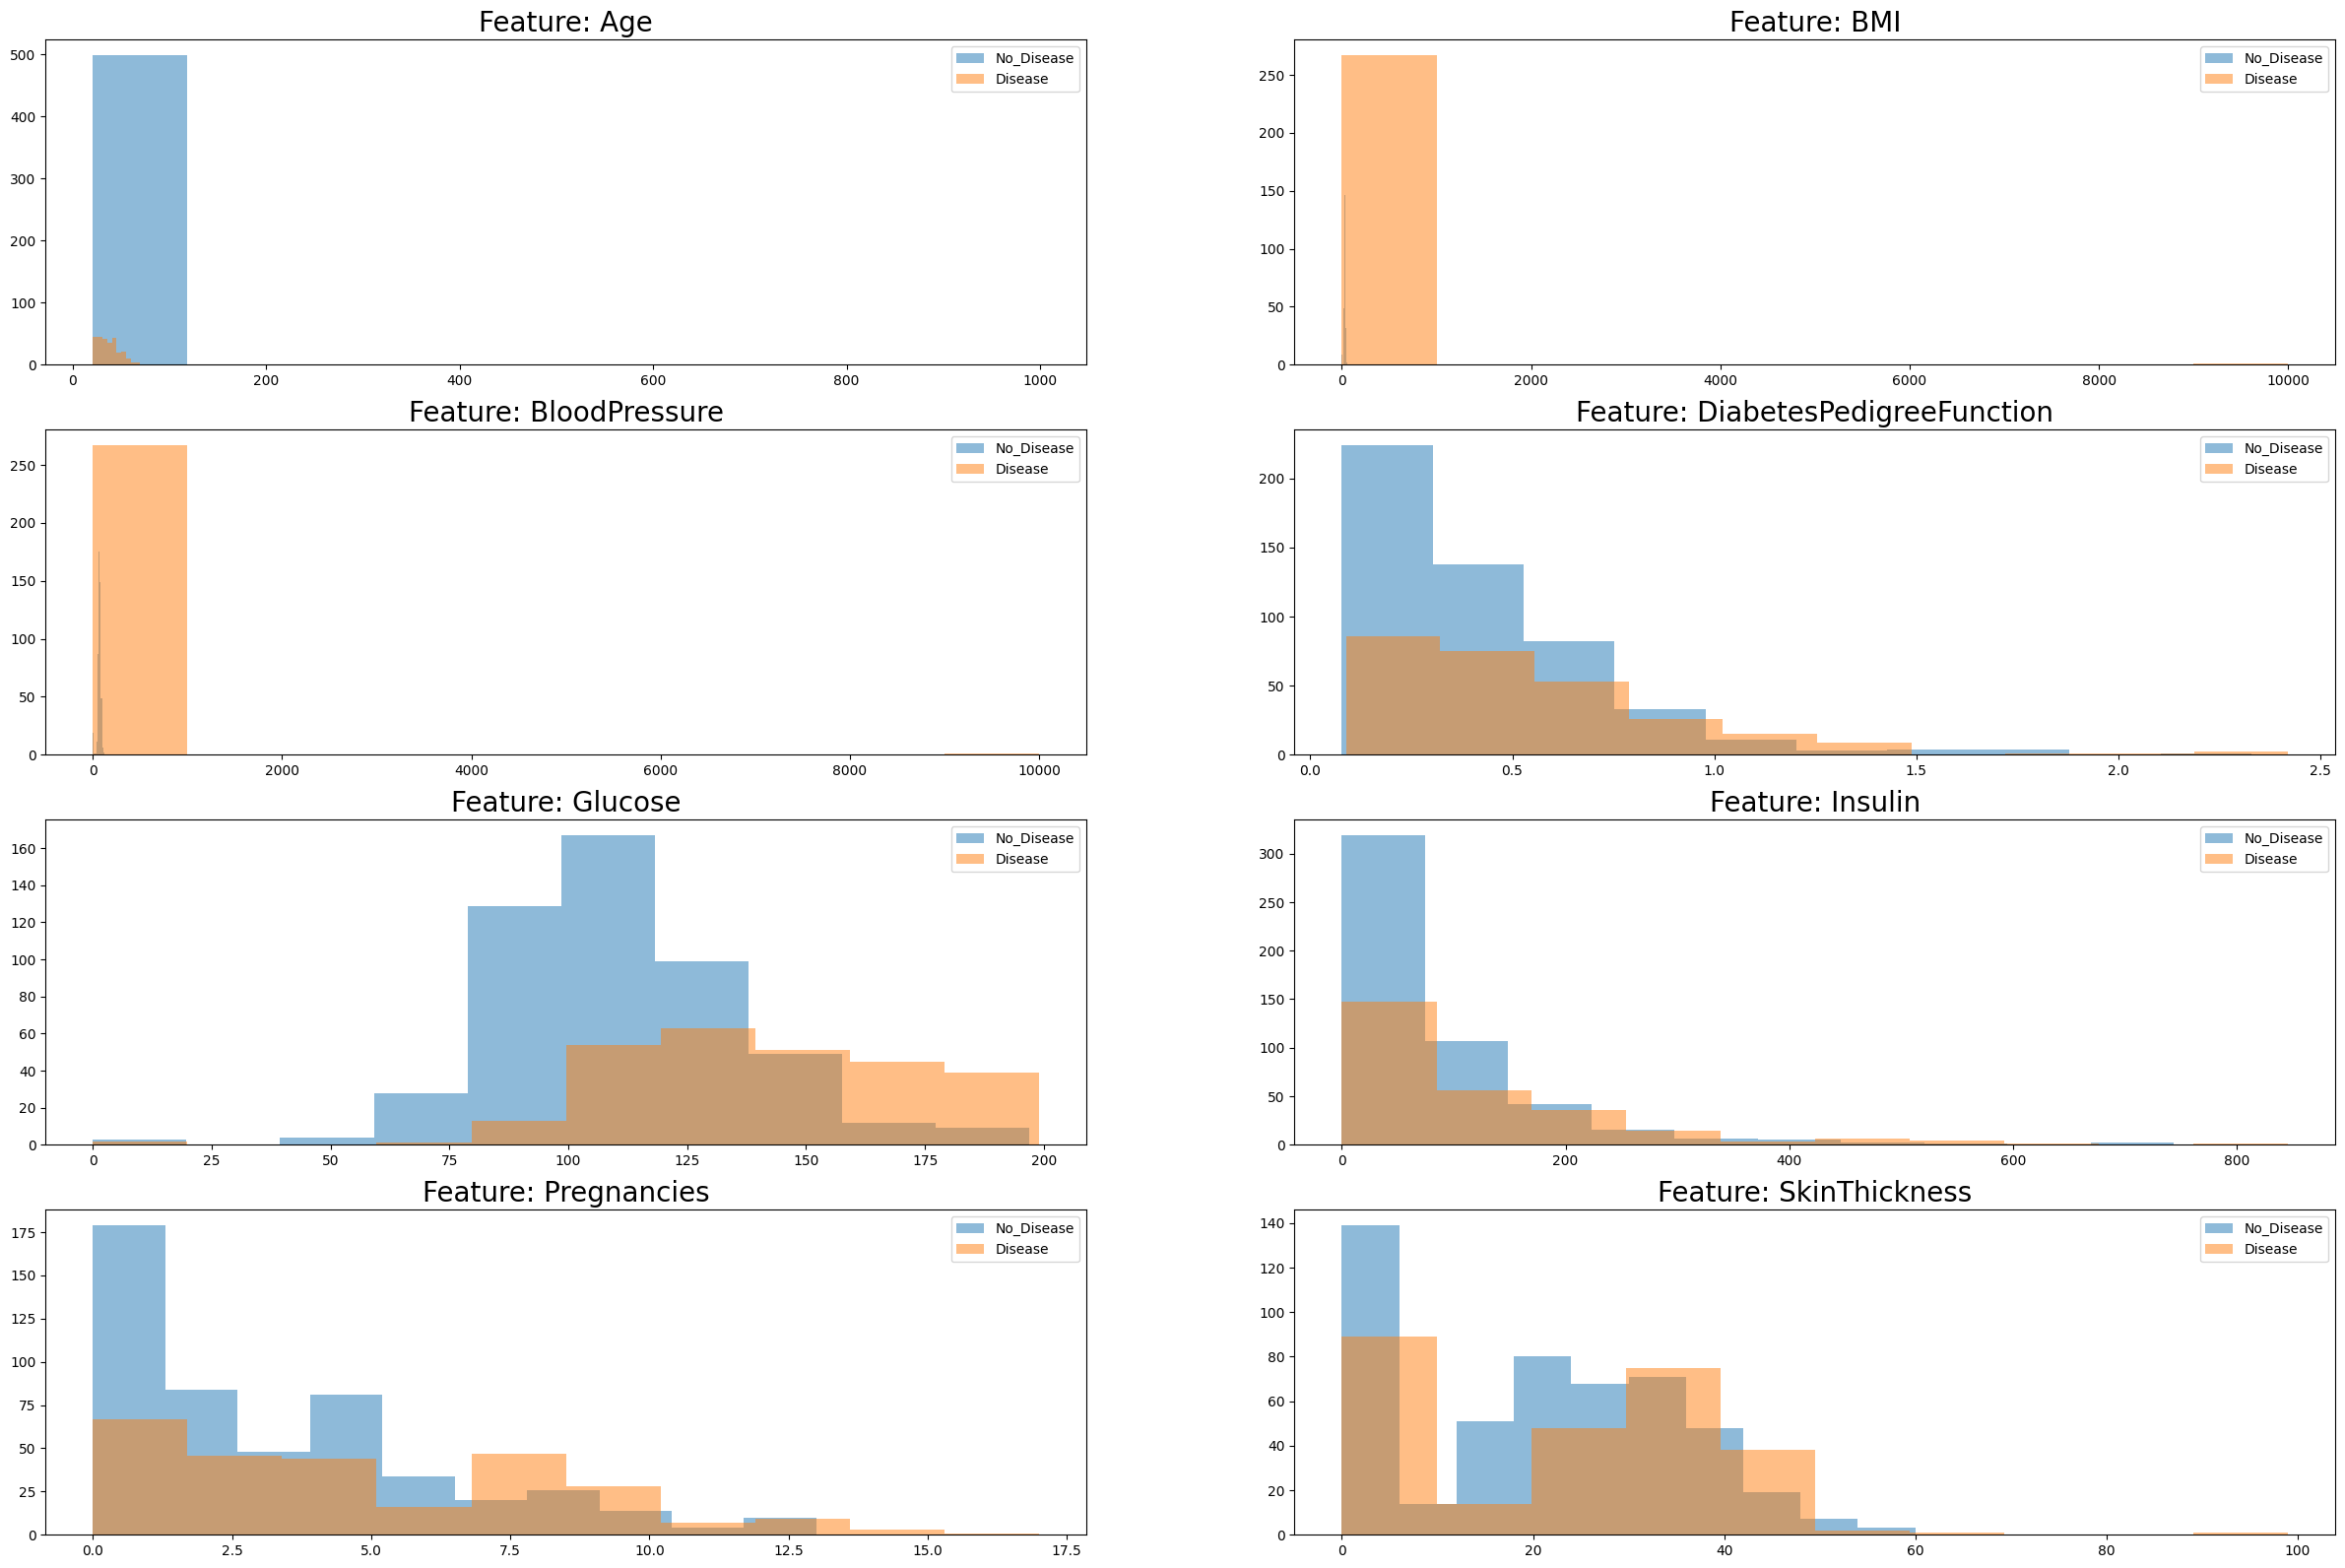

In [22]:
df_nooutlier.dropna(axis = 0, how = 'any', inplace = True)

# 설명변수만 분리
x = df_nooutlier[df_nooutlier.columns.difference(['Outcome'])]
# 설명변수명 리스트
feature_name = x.columns
plt.figure(figsize=(30, 30))
for col_idx in range(len(feature_name)):
    # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
    plt.subplot(6, 2, col_idx+1)
    # 레드 와인에 해당하는 데이터 histogram 시각화
    plt.hist(df[df["Outcome"] == 0][feature_name[col_idx]], label = "No_Disease", alpha = 0.5)
    # 화이트 와인에 해당하는 데이터 histogram 시각화
    plt.hist(df[df["Outcome"] == 1][feature_name[col_idx]], label = "Disease", alpha = 0.5)
    plt.legend()
    # 그래프 타이틀: feature name
    plt.title("Feature: "+ feature_name[col_idx], fontsize = 20)
plt.show()

In [30]:
# 표준 스케일러(평균 0, 분산 1)
scaler = StandardScaler()
# 설명변수 및 목표변수 분리
x = df_nooutlier[df_nooutlier.columns.difference(['Outcome'])]
y = df_nooutlier['Outcome']
# 설명변수 데이터 스케일링
x_scaled = scaler.fit_transform(x)

- 2.1 오버샘플링 과정 설명하고 결과 작성

- 2.2 언더샘플링 과정 설명하고 결과 작성

- 2.3 둘 중 하나를 선택하고 이유 설명



In [31]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns


undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(x_scaled, y)
print(Counter(y_under))

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(x_scaled, y)
print(Counter(y_over))

smote_sample = SMOTE(sampling_strategy='minority') 
X_sm, y_sm = smote_sample.fit_resample(x_scaled, y)
print(Counter(y_sm))


Counter({0: 200, 1: 200})
Counter({1: 439, 0: 439})
Counter({1: 439, 0: 439})


- 3.1 최소 3개 이상 알고리즘 제시하고 정확도 측면의 모델 1개와 속도 측면의 모델 1개를 꼭 구현(총 2개 이상)

- 3.2 모델 비교하고 결과 설명

- 3.3 속도 개선을 위한 차원 축소 설명하고 수행, 예측 성능과 속도 비교하고 결과 작성



금속 성분 함유량 데이터(변수 1개) - 제품에 금속 재질 함유량의 분산이 1.3을 넘으면 불량이라고 보고 있는데 제조사별로 차이가 난다고 제보를 받았으며, 분산에 대해 검정을 수행하시오. (유의확률 0.05)

4.1 연구가설과 귀무가설 작성

4.2 양측 검정 시행

4.3 검정통계량, 가설채택


In [2]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/22/content.csv')
df.head()

,content
0,97.995295
1,101.478315
2,102.284913
3,98.993634
4,104.635232


Lot별 200개에 대한 불량 제품 수량 데이터(변수 2개 - lot번호, 불량제품수)

5.1 불량률 관리도에 따라 관리중심선(CL : Center Line), 관리 상한선(UCL : Upper Control Limit), 하한선(LCL : Lower Control Limit) 구하기

5.2 관리도 시각화

In [3]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/22/error.csv')
df.head()

,iot_number,error_case_number
0,1,4.5
1,2,2.5
2,3,2.0
3,4,3.0
4,5,0.5
